# FIFA Player Analysis and Prediction using RNN

This notebook implements an advanced player analysis and prediction system using Recurrent Neural Networks (RNN) with TensorFlow. We'll analyze FIFA player data to predict future performance based on current statistics.

## 1. Import Required Libraries

Let's import all the necessary libraries for our project:

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Preprocessing

Let's load the FIFA players dataset and perform initial preprocessing:

In [11]:
# Load the dataset
df = pd.read_csv('data/players_20.csv')

# Select relevant features
features = ['age', 'Overall', 'potential', 'value_eur', 'wage_eur',
           'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

# Clean and prepare data
df['value_eur'] = df['value_eur'] / 1000000  # Convert to millions
df['wage_eur'] = df['wage_eur'] / 1000  # Convert to thousands

# Print columns before dropping NaNs to diagnose
print("DataFrame columns before dropna:", df.columns.tolist())

# Remove any missing values
df = df.dropna(subset=features)

# Select the features
df = df[features]


# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

DataFrame columns before dropna: ['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club', 'Overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_bala

## 3. Exploratory Data Analysis

Let's analyze the relationships between different player attributes:

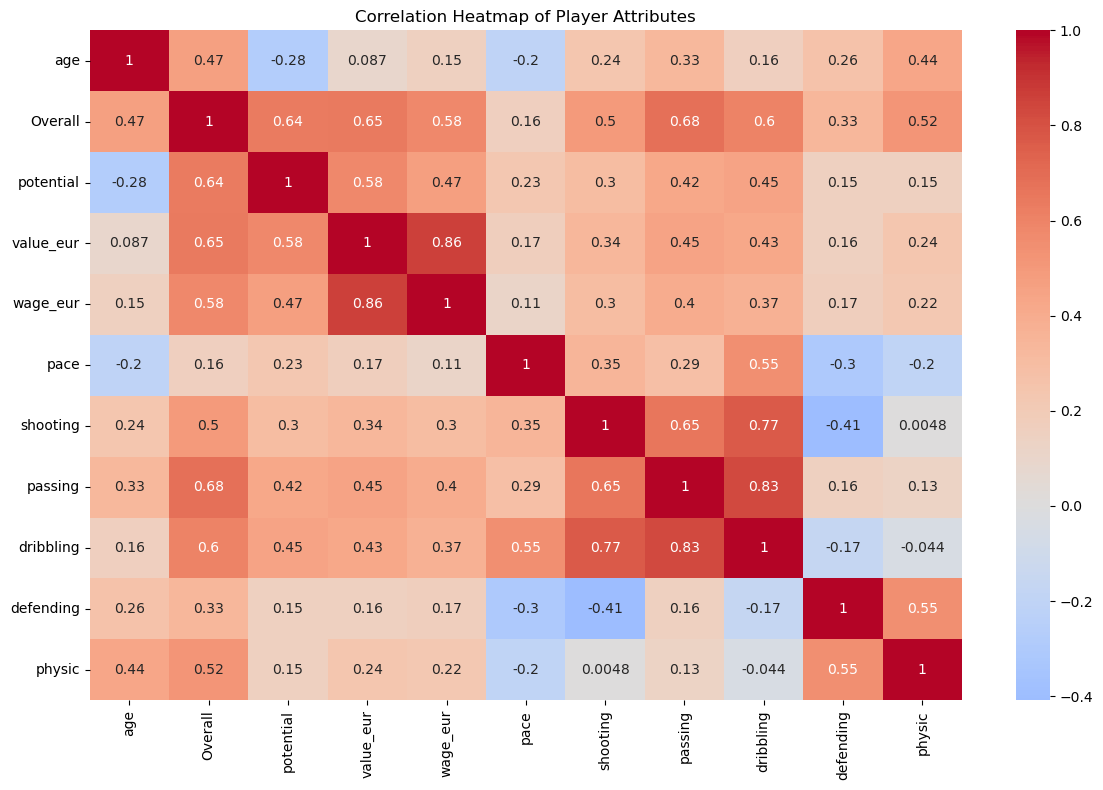

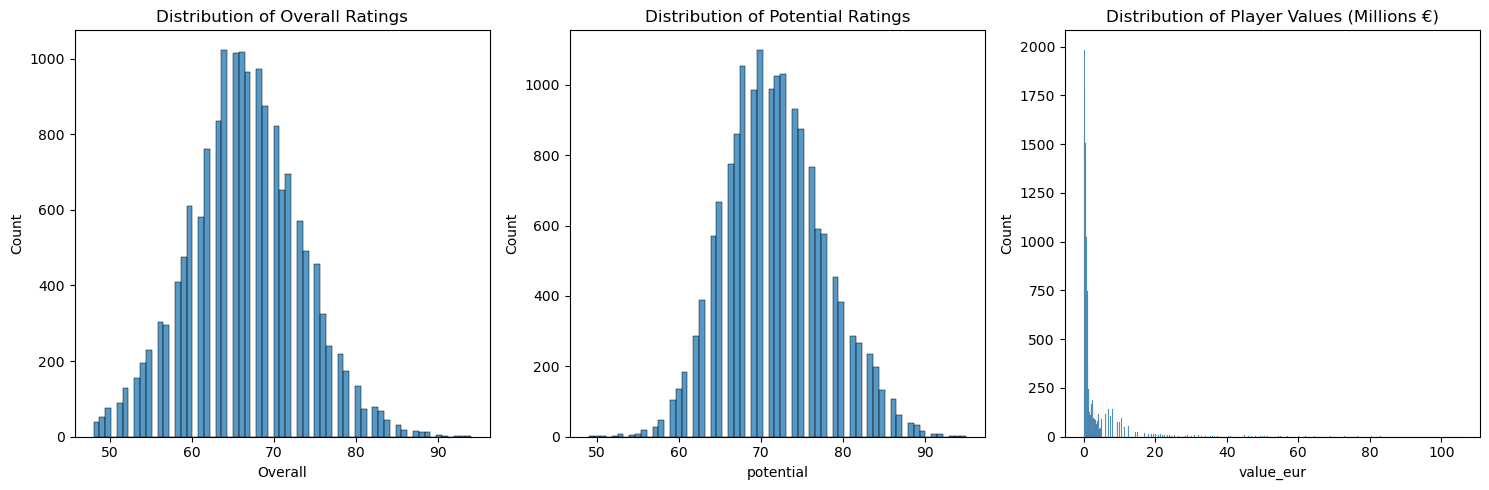

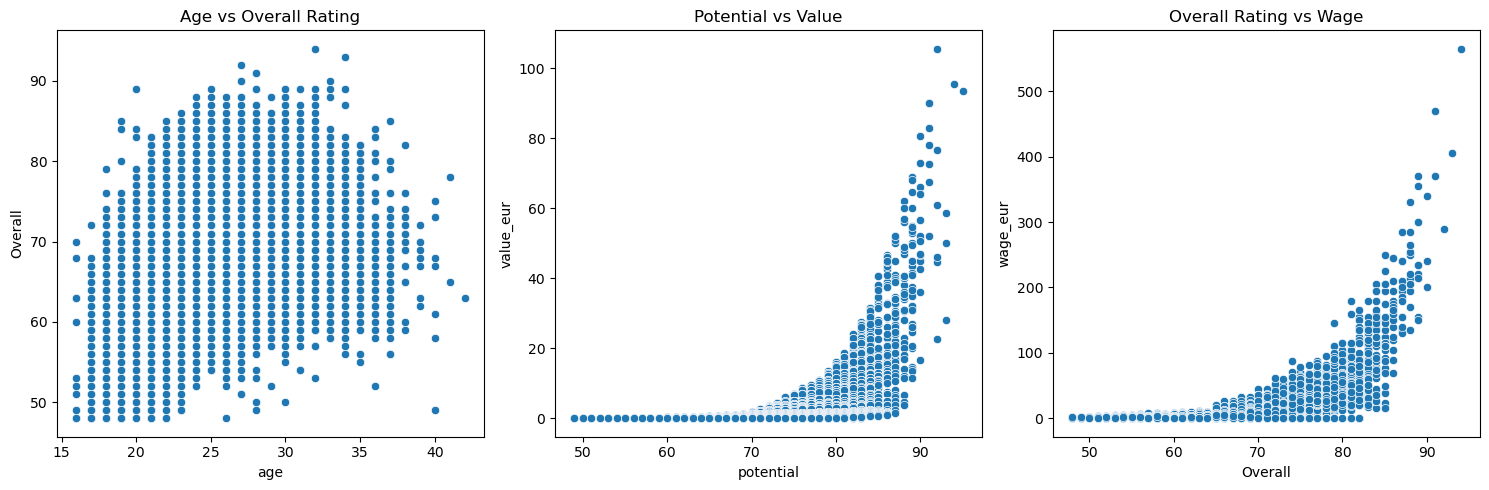

In [12]:
# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Player Attributes')
plt.tight_layout()
plt.show()

# Create distribution plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data=df, x='Overall')
plt.title('Distribution of Overall Ratings')

plt.subplot(1, 3, 2)
sns.histplot(data=df, x='potential')
plt.title('Distribution of Potential Ratings')

plt.subplot(1, 3, 3)
sns.histplot(data=df, x='value_eur')
plt.title('Distribution of Player Values (Millions €)')
plt.tight_layout()
plt.show()

# Create scatter plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='age', y='Overall')
plt.title('Age vs Overall Rating')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='potential', y='value_eur')
plt.title('Potential vs Value')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x='Overall', y='wage_eur')
plt.title('Overall Rating vs Wage')
plt.tight_layout()
plt.show()

## 4. Data Preparation for RNN

Let's prepare our data for the RNN model:

In [13]:
# Prepare features and target
X = df[['age', 'Overall', 'potential', 'value_eur']].values
y = df[['Overall', 'potential', 'value_eur']].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

# Create sequences for RNN
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (12992, 1, 4)
Testing set shape: (3249, 1, 4)


## 5. Building RNN Model

Let's create our advanced RNN model with 6 hidden layers:

In [14]:
# Build the RNN model
model = Sequential([
    # 1st LSTM layer
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),

    # 2nd LSTM layer
    LSTM(96, return_sequences=True),
    Dropout(0.3),

    # 3rd LSTM layer
    LSTM(64, return_sequences=True),
    Dropout(0.3),

    # 4th LSTM layer
    LSTM(48, return_sequences=True),
    Dropout(0.3),

    # 5th LSTM layer
    LSTM(32, return_sequences=True),
    Dropout(0.3),

    # 6th LSTM layer
    LSTM(24, return_sequences=False),
    Dropout(0.3),

    # Dense layers with different activation functions
    Dense(64, activation='relu'),
    Dense(48, activation='elu'),
    Dense(32, activation='selu'),
    Dense(24, activation='tanh'),
    Dense(16, activation='swish'),
    Dense(8, activation='sigmoid'),

    # Output layer
    Dense(3, activation='softmax')  # 3 outputs: overall, potential, value
])

# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 1, 128)              │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 96)               │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 96)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 1, 64)               │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 1, 48)               │          21,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 48)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 32)               │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 24)                  │           5,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 48)                  │           3,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 24)                  │             792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,891 (940.98 KB)

 Trainable params: 240,891 (940.98 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Training

Let's train our model with early stopping and learning rate reduction:

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 50ms/step - loss: 1.1176 - mae: 0.8157 - val_loss: 1.0315 - val_mae: 0.7647 - learning_rate: 0.0010
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1.0164 - mae: 0.7795 - val_loss: 1.0097 - val_mae: 0.7523 - learning_rate: 0.0010
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.9675 - mae: 0.7582 - val_loss: 0.9925 - val_mae: 0.7487 - learning_rate: 0.0010
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.0250 - mae: 0.7682 - val_loss: 0.9768 - val_mae: 0.7431 - learning_rate: 0.0010
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.9633 - mae: 0.7546 - val_loss: 0.9698 - val_mae: 0.7415 - learning_rate: 0.0010
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.9252 - mae: 0.7479 - val_loss: 0.9642 - val_mae: 0.7397 - learning_rate: 0.0010
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.9353 - mae: 0.7464 - val_loss: 0.9562 - val_mae: 0.7367 - learning_rate

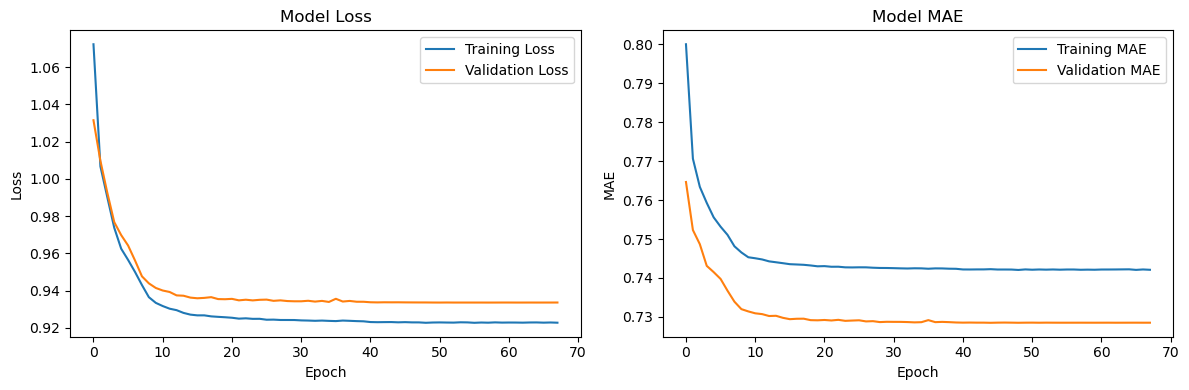

In [15]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Model Evaluation

Let's evaluate our model's performance:

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step
Mean Absolute Error:
Overall: 5.29
Potential: 4.57
Value: 4.04M €

Root Mean Square Error:
Overall: 6.60
Potential: 5.68
Value: 6.04M €


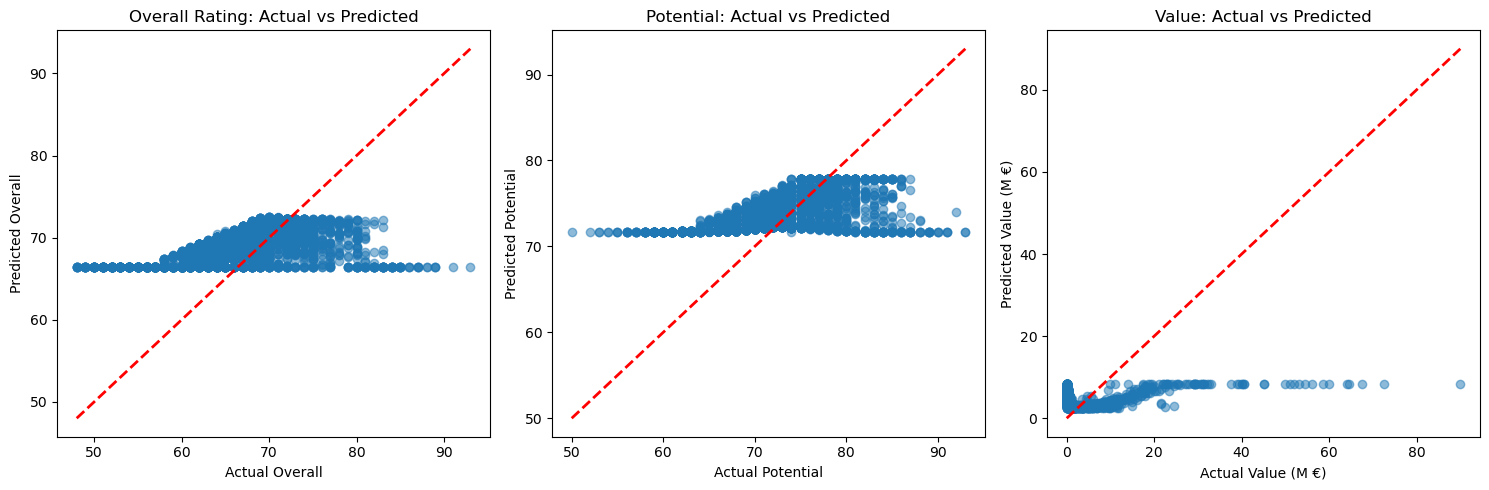

In [16]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Calculate metrics
mae = np.mean(np.abs(y_pred_original - y_test_original), axis=0)
mse = np.mean((y_pred_original - y_test_original)**2, axis=0)
rmse = np.sqrt(mse)

print("Mean Absolute Error:")
print(f"Overall: {mae[0]:.2f}")
print(f"Potential: {mae[1]:.2f}")
print(f"Value: {mae[2]:.2f}M €")

print("\nRoot Mean Square Error:")
print(f"Overall: {rmse[0]:.2f}")
print(f"Potential: {rmse[1]:.2f}")
print(f"Value: {rmse[2]:.2f}M €")

# Plot actual vs predicted values
plt.figure(figsize=(15, 5))

# Overall Rating
plt.subplot(1, 3, 1)
plt.scatter(y_test_original[:, 0], y_pred_original[:, 0], alpha=0.5)
plt.plot([y_test_original[:, 0].min(), y_test_original[:, 0].max()],
         [y_test_original[:, 0].min(), y_test_original[:, 0].max()],
         'r--', lw=2)
plt.xlabel('Actual Overall')
plt.ylabel('Predicted Overall')
plt.title('Overall Rating: Actual vs Predicted')

# Potential
plt.subplot(1, 3, 2)
plt.scatter(y_test_original[:, 1], y_pred_original[:, 1], alpha=0.5)
plt.plot([y_test_original[:, 1].min(), y_test_original[:, 1].max()],
         [y_test_original[:, 1].min(), y_test_original[:, 1].max()],
         'r--', lw=2)
plt.xlabel('Actual Potential')
plt.ylabel('Predicted Potential')
plt.title('Potential: Actual vs Predicted')

# Value
plt.subplot(1, 3, 3)
plt.scatter(y_test_original[:, 2], y_pred_original[:, 2], alpha=0.5)
plt.plot([y_test_original[:, 2].min(), y_test_original[:, 2].max()],
         [y_test_original[:, 2].min(), y_test_original[:, 2].max()],
         'r--', lw=2)
plt.xlabel('Actual Value (M €)')
plt.ylabel('Predicted Value (M €)')
plt.title('Value: Actual vs Predicted')

plt.tight_layout()
plt.show()

## 8. Save Model

Let's save our trained model for use in the Flask application:

In [17]:
# Save the model
model.save('model/fifa_player_model.h5')

# Save the scaler
with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully!")

Model and scaler saved successfully!
